### HD SNP Phasing Using Bowtie Version 3.3
### offline matplotlib version


### Important Notes:

* This version requires previously determined zygosity information for SNPS (rs362331, rs362307)
* This version requires previously determined CAG repeat lengths.
* This version uses the native Python matplotlib library for all visualizations
* This version containes a 75% CAG content filter for extracted CAG repeats. (Tunable parameter)


This algorithm is described in: Svrzikapa et al, Investigational assay for haplotype phasing of the huntingtin gene
https://doi.org/10.1016/j.omtm.2020.09.003

The purpose of the algorithm is to investigate heterozygous samples at the prevalent HD SNPs (rs362331 and rs362307) and determine if the allele carrying the expanded CAG repeat also has a U at the SNPs of interest.  Given that these SNPs are distant from the CAG repeat even, this task is difficult to solve with traditional NGS short read sequencing.  Here we use PacBio long read sequencing to generate reads which capture both the SNPs and the CAG repeat regions.

For more information please take a look at the manuscript and do not hesitate to contact the authors.

### What do I need to run this algorithm?

The algorithm is in pure python 3.x. setup in a conda environment and runs in the Jupyter Notebook.
Outside of this Bowtie is required to be accessible on the command line.
This can easily be installed via conda as well.

### What kind of sequencing file do you need to run this file?

We amplify a ~9.8 kb region of the HTT mRNA and sequence it with PacBio.
In theory any PacBio or Nanopore reads that contain the long CAG repeat and the above SNPs can be used.
We recommend high quality CCS (circular consensus reads).
A fasta format of the reads is required and the bowtie index is generated at runtime.
If you would like to generate the bowtie indexes manually, you can bypass the bowtie index generation and provide the bowtie index in the same folder.

### Can I investigate phasing other HD SNPs with this algorithm?

Yes.  As long as they are in your reads.  You would need to adjust section 3 (All potential sequences around those SNPs)

### How do I answer the questions at the beginning of the script?

It's important to note that we have prior CAG repeat length and known zygocity as described in the manuscript.  We use this information in order to not sequence homozygous samples.  If you don't have prior CAG or zygocity information just put arbitrary values and say that your sample is heterozygous.  

### Why have you not provided a test sequencing file on Github?

Long range sequencing files are large and the test file presented is ~3GB and as such exceeds the upload limit of Github.
Please contact the authors to get access to the test file if required.

### Importing Libraries

In [1]:
from Bio import SeqIO
import sys
import os
import time
import numpy as np
import pandas as pd
from math import floor as floor
import math
import subprocess
from IPython.display import HTML, display
from scipy.stats import beta
import scipy.integrate as integrate
from numpy import array
from sqlalchemy import *
from sqlalchemy.sql.expression import bindparam
import pymysql
import json
from datetime import datetime
import matplotlib.pyplot as plt

### Facility Details

In [2]:
#Change when sending to facility
facility = "External_User"
script_version = "3.3"
print ("This is script version:",script_version)

This is script version: 3.3


### 1. User Input and Filtering the original Fasta file by length


#### User Input

The user is instructed to enter zygocity information for rs362331 and rs362307.  This entry is used in order to run or not run the final statistical analysis and call.  i.e. A sample that is homozygous for either SNP is automatically ineligible for that SNP.  Hence it is not necessary to run statistical analysis  for that SNP.


#### Fasta Filtering

The majority of the subreads Fasta file is comprised of sequences that theoretically are too short to have the CAG repeat and both rs362331 and rs362307 regions.  We set a lower limit of 9kb to get rid of any read that is shorter than 9kb.  The sample_id + "_filtered.fasta" filename is used for all subsequent analysis.  This significantly decreases the time it takes to build a bowtie index for any given sample and allows for analysis without the need of significant computational power.

#### Error checking

The user must provide a valid .fasta file in the folder where the script executes.  Failure to do so, providing an incorrect filename, or not having privileges to write to that folder will result in throwing an exception that will abort any further analysis.



In [3]:
fasta_file = "" #stores full name of untrimmed fasta file to be analyzed
sample_id = "" #stores sample id (used to propagate sample id for all output)
sanger_rs362331_het = False #preset Sanger information for rs362331 to NOT heterozygous
sanger_rs362307_het = False #preset Sanger information for rs362307 to NOT heterozygous
confirmed_sanger_rs362331_het = False #preset Sanger confirmation for rs362331 to not confirmed
confirmed_sanger_rs362307_het = False #preset 
sanger_data_available = False
analyst_information = ""
measured_short_cag = 0
measured_long_cag = 0



#Eligibility variables primed at NOT ELIGIBLE
rs_362331_eligibility = "NOT ELIGIBLE"
rs_362307_eligibility = "NOT ELIGIBLE"

#Comments (List of strings providing further information on eligibility calls)
comments = []

#Analyst Instructions
print ("Please press enter after answering each of the following questions.\n")
print ("This script is designed to analyze Pacbio .fasta output files where for each read in that file \nwe associate 2 SNPS in the Huntingtin gene: (rs362331 and rs362307) with a length of a CAG repeat expansion \npresent at the 5' of that read. \n")

#Does Analyst have Sanger information necessary to proceed with analysis?
print ("Before analysis the analyst has to confirm that at least 1 of the SNP loci is heterozygous T/C.")
print ("Hence, before proceeding the analyst must have the Sanger data available.")
sanger_data_available = input ("\nDo you have zygocity information available for rs362331 and rs362307? (y/n): ")
if sanger_data_available in ["y","Y","yes","YES","Yes"]:
    sanger_data_available = True
else:
    sys.exit("\nAborting analysis! You must have zygocity information in order to proceed.")

    
cag_data_available = input ("\nDo you have CAG size data available for this sample? (y/n): ")
if cag_data_available in ["y","Y","yes","YES","Yes"]:
    cag_data_available = True
    try:
        measured_short_cag = input("Please enter the CAG repeat size for the short allele:")
        measured_long_cag = input("Please enter the CAG repeat size for the long allele:")
        print ("\nYou entered Short CAG:" , measured_short_cag , " Long CAG:" ,  measured_long_cag)
        confirm_cag = input("\nIs this correct? (y/n)")
        if confirm_cag in ["y","Y","yes","YES","Yes"]:
            confirm_cag = True
            measured_short_cag = int(measured_short_cag)
            measured_long_cag = int(measured_long_cag)
            
        else:
            sys.exit("\nAborting analysis! Failed to confirm CAG size input.") 
    except:
        sys.exit("\nAborting analysis! Size not an integer.")

else:
    sys.exit("\nAborting analysis! You must have zygocity information in order to proceed.")    
    

#Analyst First and Last name or unique ID
analyst_information = input ("\nPlease enter your First Last name or unique ID: ")
if len(analyst_information) > 0 and not (analyst_information.isspace()):
    pass
else:
    sys.exit("Aborting analysis! Failed to enter analyst name or id")

#Getting the .fasta filename to be analyzed
print ("\nNote: The fasta filename must have the same id as the patient sample.")
try:
    fasta_file = input("\nPlease use .fasta instead of .fa when exporting your fasta file.\nPlease enter the .fasta filename including the .fasta extension.\n")
    if ".fasta" not in fasta_file:
        sys.exit(".fasta extension not provided or not a fasta file.")
    else:
        #Getting sample_id from fasta_file name
        sample_id = fasta_file[:-6]

        #Analyst input for rs362331
        sanger_input_rs362331 = input("\nUpon reviewing the Sanger results " + sample_id +  " is heterozygous T/C at rs362331 (y/n)")
        if sanger_input_rs362331 in ["y","Y","yes","YES","Yes"]:
            sanger_rs362331_het = True
            confirmation_sanger_rs362331_het = input("You entered: Heterozygous T/C for rs362331. Is this correct? (y/n)")
            if confirmation_sanger_rs362331_het in ["y","Y","yes","YES","Yes"]:
                sanger_rs362331_het = True
                confirmed_sanger_rs362331_het = True          
            else:
                sys.exit("\nAborting analysis! Analyst input for rs362331 not confirmed.")
        elif sanger_input_rs362331 in ["n","N","no","NO","No"]:
            sanger_rs362331_het = False
            confirmation_sanger_rs362331_het = input("You entered: NOT Heterozygous T/C for rs362331. Is this correct? (y/n)")
            if confirmation_sanger_rs362331_het in ["y","Y","yes","YES","Yes"]:
                sanger_rs362331_het = False
                confirmed_sanger_rs362331_het = True          
            else:
                sys.exit("\nAborting analysis! Analyst input for rs362331 not confirmed.")
                      
                
        #Analyst input for rs362307       
        sanger_input_rs362307 = input("\nUpon reviewing the Sanger results " + sample_id +  " is heterozygous T/C at rs362307 (y/n)")
        if sanger_input_rs362307 in ["y","Y","yes","YES","Yes"]:
            sanger_rs362307_het = True
            confirmation_sanger_rs362307_het = input("You entered: Heterozygous T/C for rs362307. Is this correct? (y/n)")
            if confirmation_sanger_rs362307_het in ["y","Y","yes","YES","Yes"]:
                sanger_rs362307_het = True
                confirmed_sanger_rs362307_het = True          
            else:
                sys.exit("\nAborting analysis! Analyst input for rs362307 not confirmed.")
        elif sanger_input_rs362307 in ["n","N","no","NO","No"]:
            sanger_rs362307_het = False
            confirmation_sanger_rs362307_het = input("You entered: NOT Heterozygous T/C for rs362307. Is this correct? (y/n)")
            if confirmation_sanger_rs362307_het in ["y","Y","yes","YES","Yes"]:
                sanger_rs362307_het = False
                confirmed_sanger_rs362307_het = True          
            else:
                sys.exit("\nAborting analysis! Analyst input for rs362331 not confirmed.")
        
      
        #This should never happen since a sample like this will not go into PacBio sequencing
        #However if the use makes a mistake and enters homozygous for both SNPs the script aborts.
        if sanger_rs362331_het == False and sanger_rs362307_het == False:
            sys.exit("\nAborting analysis! Analyst input for both SNPs is homozygous.")
        else:
            #Filtering the fasta files and saving a _filtered.fasta file in the same folder
            print("\nInitiating filtering of reads shorter than 9kb for: ",fasta_file)
            seq_length_cutoff = 9000
            file = SeqIO.parse(open(fasta_file, "r"), "fasta")
            valid_sequences = (record for record in file if len(record.seq) > seq_length_cutoff)

            output_handle = open(sample_id + "_filtered.fasta", "w")
            SeqIO.write(valid_sequences, output_handle, "fasta")
            output_handle.close()
            print("Filtered out sequences shorter than 9kb.")
except:
    print("File not found!  Please ensure you include .fasta extension or check if file exists in directory.")
    print("If you are using .fa extention, please rename to .fasta and rerun.")
    sys.exit("\nAborting analysis! File not found or improper file input!")

Please press enter after answering each of the following questions.

This script is designed to analyze Pacbio .fasta output files where for each read in that file 
we associate 2 SNPS in the Huntingtin gene: (rs362331 and rs362307) with a length of a CAG repeat expansion 
present at the 5' of that read. 

Before analysis the analyst has to confirm that at least 1 of the SNP loci is heterozygous T/C.
Hence, before proceeding the analyst must have the Sanger data available.

Do you have zygocity information available for rs362331 and rs362307? (y/n): y

Do you have CAG size data available for this sample? (y/n): y
Please enter the CAG repeat size for the short allele:17
Please enter the CAG repeat size for the long allele:44

You entered Short CAG: 17  Long CAG: 44

Is this correct? (y/n)y

Please enter your First Last name or unique ID: Test User

Note: The fasta filename must have the same id as the patient sample.

Please use .fasta instead of .fa when exporting your fasta file.
Plea

### 2. Build Bowtie Index

After filtering the original subreads fasta file, we use the sample_filtered.fasta file to generate a bowtie index.
The name of the bowtie index is the sample_id

#### Error checking:

We use the check_call subprocess function which throws an exception if this process fails.
Any further analysis is aborted if this happens.

If executing via the jupyter notebook this process can be monitored in the terminal.

In [4]:
infile = sample_id + "_filtered.fasta"
outfile = sample_id
try:
    subprocess.check_call(["bowtie-build",infile,outfile])
    print("Bowtie index built from: ",infile)
except:
    print("Unable to complete bowtie-build command.  Check if bowtie is in path and file exists in directory.")
    sys.exit("Aborting analysis! Failed to build index.")

Bowtie index built from:  GM01169f_filtered.fasta


### 3. Generate fasta files for bowite SNP and CAG boundary queries

These are the sequences that we programmatically generate to query the bowtie index.
They include:

1. The boundaries of the CAG repeat sequence
2. 20nt sequences around the SNP regions

Note that the length of these sequences influences the outcome of the algorithm.  In addition to that, the number of allowed mismatches given to Bowtie also influences the outcome of the algorithm.

i.e. a longer sequences around the CAG boundaries or less mismatches allowed will provide better accuracy, but at the expense of the ammount of reads we get for looking up the SNPs.  The 20nt SNP region sequences are looked up with 0 mismatches allowed.

Note: This generates two files in the folder where the script runs:

1. cag_boundaries_b.fasta and
2. snp_queries.fasta

In [5]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

cag_boundaries = [SeqRecord(seq=Seq('CCCTCAAGTCCTTC'), id ='5_cag_border',description=''),
                  SeqRecord(seq=Seq('CAACAGCCGCCACC'), id ='3_cag_border',description='')]

snp_queries = [SeqRecord(seq=Seq('TCCCTCATCAACTGTGTGCA'), id ='rs362331_A',description=''),
               SeqRecord(seq=Seq('TCCCTCATCCACTGTGTGCA'), id ='rs362331_C',description=''),
               SeqRecord(seq=Seq('TCCCTCATCGACTGTGTGCA'), id ='rs362331_G',description=''),
               SeqRecord(seq=Seq('TCCCTCATCTACTGTGTGCA'), id ='rs362331_T',description=''),
               SeqRecord(seq=Seq('GGAAGTCTGAGCCCTTGTGC'), id ='rs362307_A',description=''),
               SeqRecord(seq=Seq('GGAAGTCTGCGCCCTTGTGC'), id ='rs362307_C',description=''),
               SeqRecord(seq=Seq('GGAAGTCTGGGCCCTTGTGC'), id ='rs362307_G',description=''),
               SeqRecord(seq=Seq('GGAAGTCTGTGCCCTTGTGC'), id ='rs362307_T',description='')]

try:
    with open("cag_boundaries_b.fasta", "w") as output_handle:
        SeqIO.write(cag_boundaries, output_handle, "fasta")
    with open("snp_queries.fasta", "w") as output_handle:
        SeqIO.write(snp_queries, output_handle, "fasta")
    
except:
    print("Failed to create query files! Please ensure you have write permissions to folder.")
    sys.exit("Aborting analysis! Failed to create query files.")   

### 4. Bowtie queries for SNPs and CAG boundaries

We query the Bowtie index with two sets of sequences.  One for the CAG boundaries where we allow up to 2 mismatches and the other for the rs261331 and rs362307 SNP regions where we do not allow any mismatches.

Ultimately we will end up with unique fasta read IDs which we can then aggregate.
i.e.  We will look for sequences that have a 5' and 3' CAG boundary and either one of the SNPs.  If the ID of the sequence is present in both files, we can use that sequence for further analysis.

Note: This generates two files in the folder where the script runs:

1. sample_snp_bow.txt and
2. sample_cag_bow.txt

In [6]:
#Bowtie query of snp_queries.fasta
#GETTING BOWTIE RESULTS FOR SNPs
try:
    subprocess.check_call(["bowtie","-a","-v","0",sample_id,"-f","snp_queries.fasta",(sample_id + "_snp_bow.txt")])
    print("Succesfully generated bowtie output for SNPs")
except:
    print("Unable to complete bowtie command.  Check if bowtie is in path and file exists in directory.")
    print("Failed to create bowtie output for SNP! Please ensure you have write permissions to folder.")
    sys.exit("Aborting analysis! Failed to execute bowtie command.")

#Bowtie query of cag_boundaries_b.fasta
#GETTING BOWTIE RESULTS FOR CAG Boundaries
try:
    subprocess.check_call(["bowtie","-a","-v","2",sample_id,"-f","cag_boundaries_b.fasta",(sample_id + "_cag_bow.txt")])
    print("Succesfully generated bowtie output for CAG boundaries")
except:
    print("Unable to complete bowtie command.  Check if bowtie is in path and file exists in directory.")
    print("Failed to create bowtie output for CAG boundaries! Please ensure you have write permissions to folder.")
    sys.exit("Aborting analysis! Failed to execute bowtie command.") 

Succesfully generated bowtie output for SNPs
Succesfully generated bowtie output for CAG boundaries


### 5. Importing Bowtie Output Files

We have two dataframes:

* df_snp containing the bowtie results of aligning 8 possible sequences with 0 mismatches at each snp
* df_cag containing the bowtie results of aligning 20nt CAG repeat edges

Going forward df stands for a Pandas Dataframe - A table like python data container.

In [7]:
df_snp = pd.read_csv(sample_id + '_snp_bow.txt',sep='\t',header=None)
df_cag = pd.read_csv(sample_id + '_cag_bow.txt',sep='\t',header=None)

#Names of Bowtie Outpus
bowtie_columns = ['query', 'strand', 'id','location','read_sequence','read_quality','other_alignments','mismatches']

#Name df columns
df_snp.columns = bowtie_columns
df_cag.columns = bowtie_columns

### 6. Splitting df_snp into 2 dataframes by SNP and Counting base at SNP position

* df_snp_rs362331
* df_snp_rs362307

In [8]:
#Add a new label column snp to be used to separate the dataframe by SNP
df_snp['snp'] = ""
df_snp.loc[(df_snp['query'].str.contains('rs362331')),'snp'] = 'rs362331'
df_snp.loc[(df_snp['query'].str.contains('rs362307')),'snp'] = 'rs362307'

#Add a new column base to be used to get base counts
#We looked up 4 possibilities for the SNP depending on which one was found we assign a base call
d = {'rs362331_A':'A', 'rs362331_C':'C', 'rs362331_G':'G', 'rs362331_T':'T',
     'rs362307_A':'A', 'rs362307_C':'C', 'rs362307_G':'G', 'rs362307_T':'T',}
df_snp['base'] = df_snp['query'].map(d)

#Groupby snp df by snp column so we can separate the data in 2 df one for each snp
g_snp = df_snp.groupby("snp")

#Now we grab each group as a separate df for each snp and reset the index   
df_snp_rs362331 = g_snp.get_group("rs362331")
df_snp_rs362307 = g_snp.get_group("rs362307")
df_snp_rs362307 = df_snp_rs362307.reset_index(drop = True)

#We Display what the user entered for zygocity based on the Sanger readout
display(HTML('<h2 style = "text-align: center;">' + sample_id + ': User Input Sanger Results</h2>'))
if sanger_rs362331_het == True:
    display(HTML('<h4 style = "text-align: left;"> rs362331: HETEROZYGOUS T/C </h4>'))
else:
    display(HTML('<h4 style = "text-align: left;"> rs362331: HOMOZYGOUS </h4>'))
    
if sanger_rs362307_het == True:
    display(HTML('<h4 style = "text-align: left;"> rs362307: HETEROZYGOUS T/C </h4>'))
else:
    display(HTML('<h4 style = "text-align: left;"> rs362307: HOMOZYGOUS </h4>'))
    

#For each snp we get a base ditribution dataframe and display the counts in a table format
df_snp_rs362331_counts = pd.DataFrame(df_snp_rs362331["base"].value_counts())
df_snp_rs362331_counts = df_snp_rs362331_counts.reset_index()
df_snp_rs362331_counts.columns = ["base","counts"]

display(HTML('<h2 style = "text-align: center;">' + sample_id + ': BASE DISTRIBUTION AT rs362331</h2>'))
display(df_snp_rs362331_counts)

df_snp_rs362307_counts = pd.DataFrame(df_snp_rs362307["base"].value_counts())
df_snp_rs362307_counts = df_snp_rs362307_counts.reset_index()
df_snp_rs362307_counts.columns = ["base","counts"]

display(HTML('<h2 style = "text-align: center;">' + sample_id + ': BASE DISTRIBUTION AT rs362307</h2>'))
display(df_snp_rs362307_counts)
display(HTML('<h3 style = "text-align: left;color: orange;">Note: Dataframes are sorted by counts.</h3>'))

#we will store these values for visualization with Plotly
values_rs362331 = []
values_rs362307 = []

#It's possible that for some bases we get 0 counts.  
#This would break the query so we update with 0 if base is not found in df query
for base in ["A","C","G","T"]:
    try:
        values_rs362331.append(int(df_snp_rs362331_counts.loc[df_snp_rs362331_counts['base'] == base,'counts']))
    except:
        values_rs362331.append(0)
    try:
        values_rs362307.append(int(df_snp_rs362307_counts.loc[df_snp_rs362307_counts['base'] == base,'counts']))
    except:
        values_rs362307.append(0)


,base,counts
0,C,10322
1,T,7750
2,A,246
3,G,185


,base,counts
0,C,10111
1,T,7354
2,A,255
3,G,161


### 7. Visualizing the Base Distribution at both SNPs with matplolib

We measure occurence of A, C, G, or T at rs362331 and rs362307

Uses values_rs362331 and values_362307 to generate a figure for Base distribution at each SNP.
We use the lists values_rs362331 and values_rs362307 which have number representing counts of:

A, C, G , T (in this order) at the SNP position.

replaces: sample_name + Base_Distribution.html 

with sample_name + Base_Distribution.png

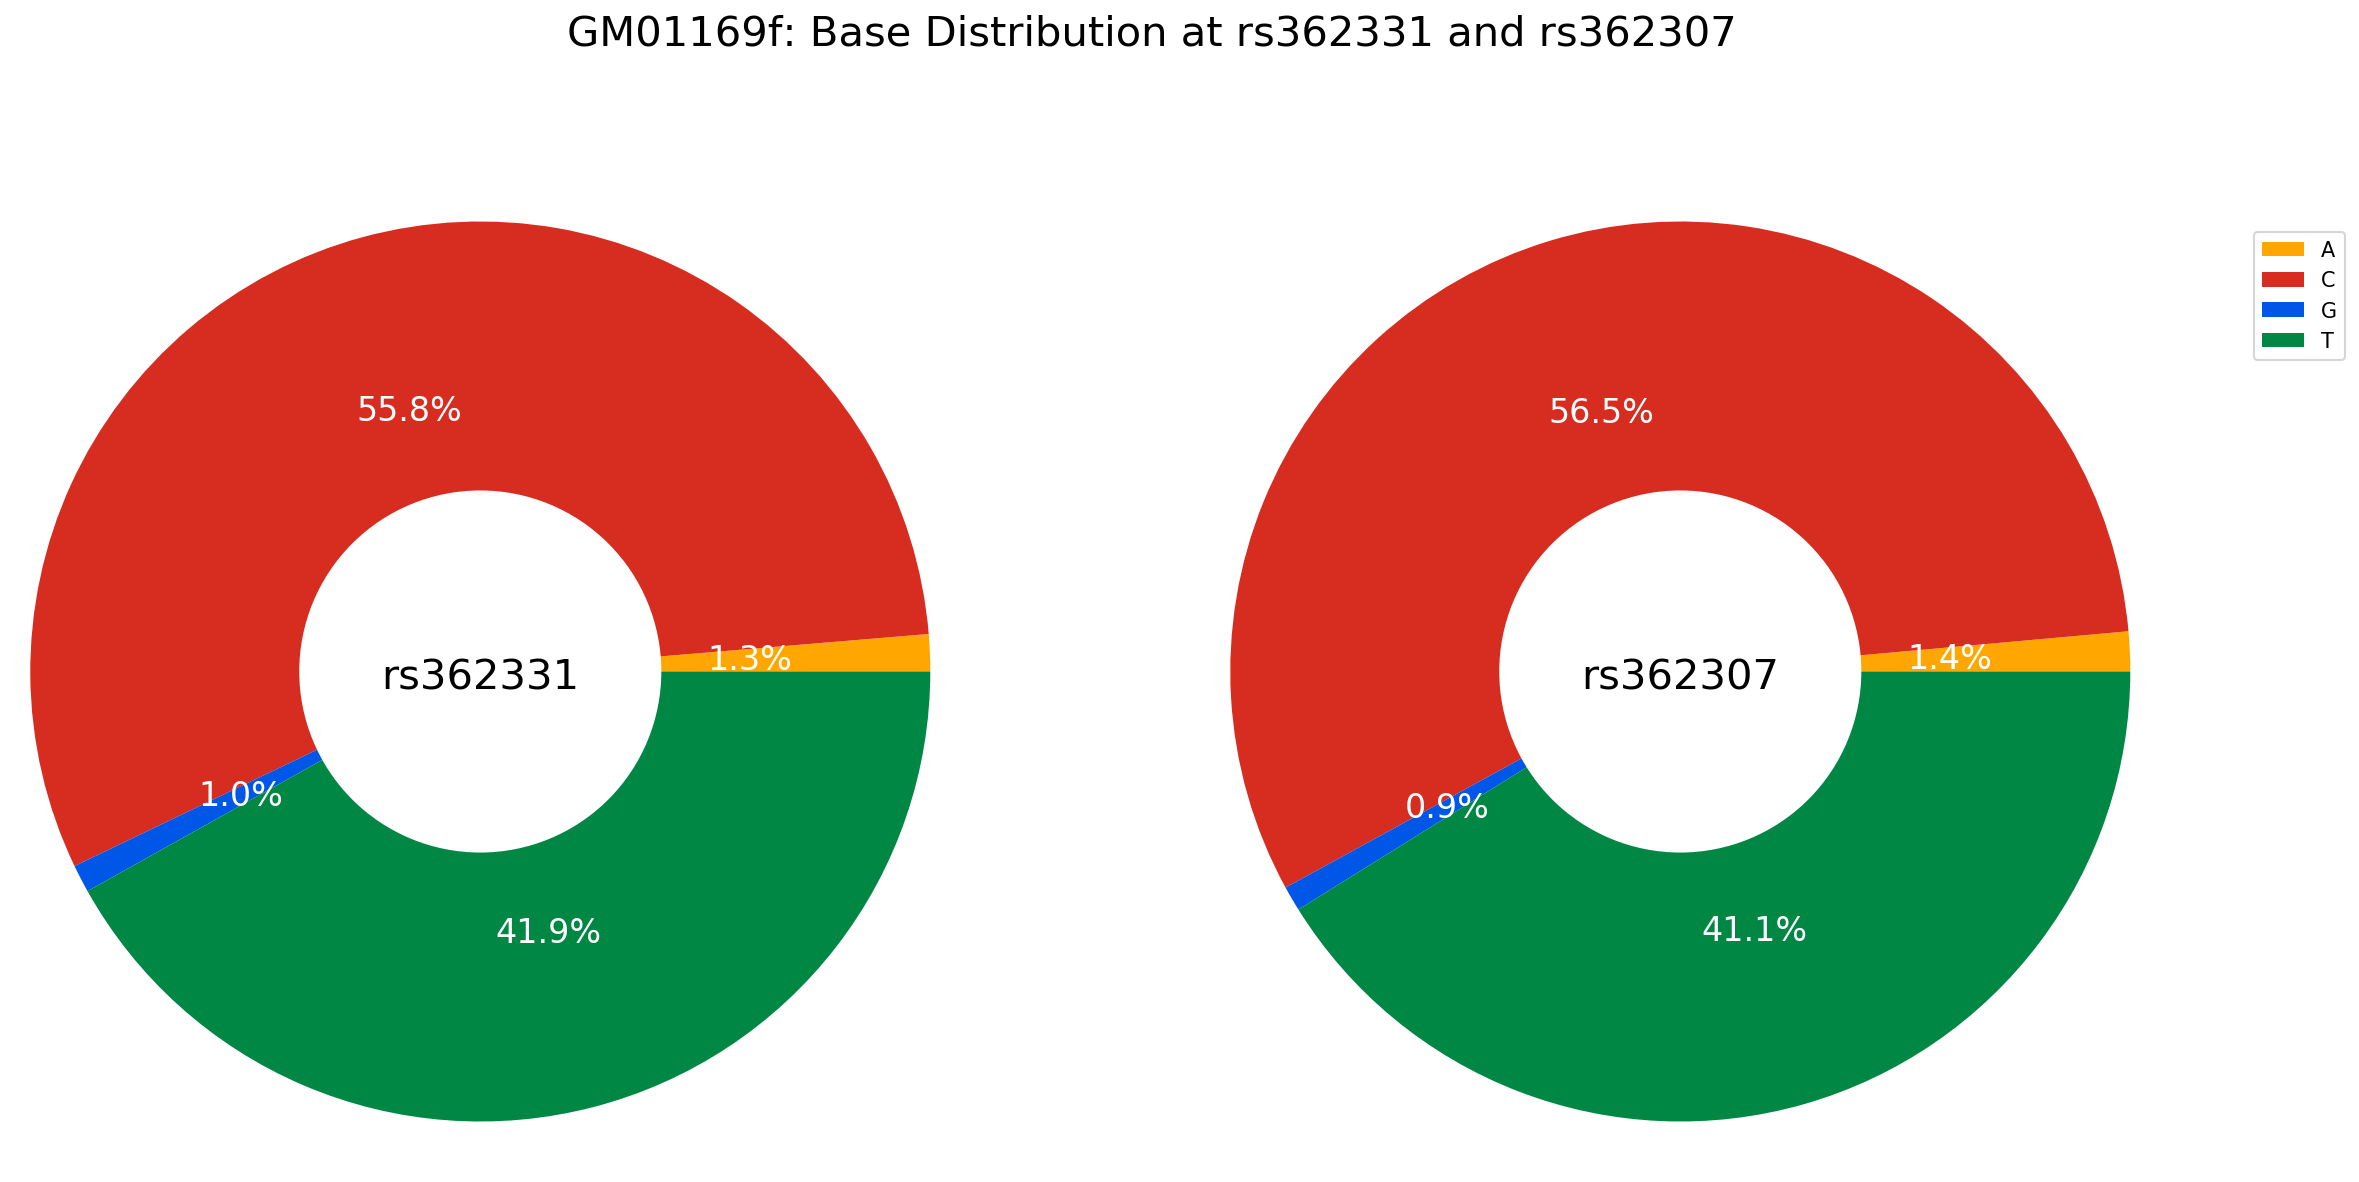

<Figure size 432x288 with 0 Axes>

In [9]:

#define labels and colors
labels = ['A', 'C', 'G', 'T']
colors = ['#ffa700','#d62d20','#0057e7','#008744']
# add a circle at the center, radius 1 color white
my_circle1=plt.Circle( (0,0), 1, color='white')
my_circle2=plt.Circle( (0,0), 1, color='white')

#create figure
fig = plt.figure(figsize=(8, 6), dpi=150)

#rs362331 left donut chart
ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(values_rs362331, labels = labels,colors = colors, radius = 2.5,autopct='%1.1f%%',textprops={'color':"w",'fontsize':16})
ax1.add_artist(my_circle1)
ax1.text(-0.55, -0.1, 'rs362331',fontsize=20)

#rs362307 right donut chart
ax2 = fig.add_axes([1, 0, .5, .5], aspect=1)
ax2.pie(values_rs362307, labels=labels,colors = colors, radius = 2.5,autopct='%1.1f%%',textprops={'color':"w",'fontsize':16})
ax2.add_artist(my_circle2)
ax2.text(-0.55, -0.1, 'rs362307',fontsize=20)

#Add and position legend
ax2.legend(labels,loc = "upper right",
          bbox_to_anchor=(1.5, 0.5, 0.5, 1))




fig.suptitle(sample_id + ": Base Distribution at rs362331 and rs362307", fontsize=20,x=0.81)

plt.savefig(sample_id + "_Base Distribution_at_rs362331_and_rs362307.png",bbox_inches='tight')

plt.show()
ax1.clear()
ax2.clear()
plt.clf()

### 7.1 Exporting Individual Donut Charts for Each SNP
#### a) rs362331 base distribution png export

replaces: sample_name + "_rs362331_base_distribution.png"

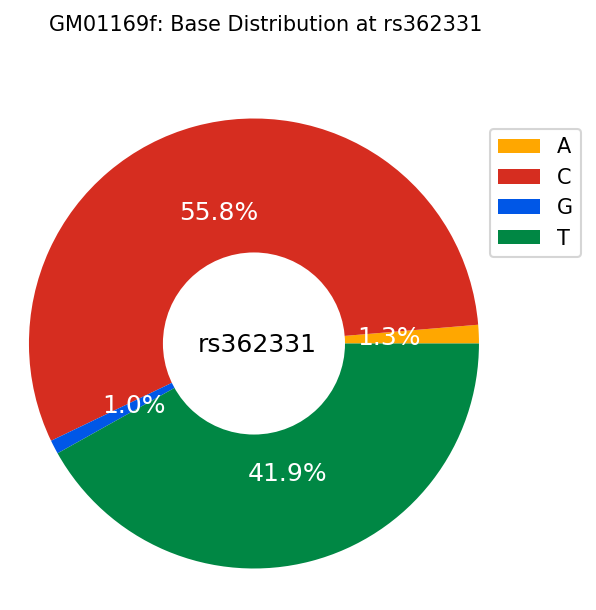

<Figure size 432x288 with 0 Axes>

In [10]:
#reusing labels and colors from 7
#circle
my_circle3=plt.Circle( (0,0), 1, color='white')

#create figure
fig = plt.figure(figsize=(4, 3), dpi=150)

#rs362331 left donut chart
ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(values_rs362331, labels = labels,colors = colors, radius = 2.5,autopct='%1.1f%%',textprops={'color':"w",'fontsize':12})
ax1.add_artist(my_circle3)
ax1.text(-0.62, -0.1, 'rs362331',fontsize=12)

#Add and position legend
ax1.legend(labels,loc = "upper right",bbox_to_anchor=(1.5, 0.5, 0.5, 1))

#Add figure title
fig.suptitle(sample_id + ": Base Distribution at rs362331", fontsize=10,x=0.27)

#Save png
plt.savefig(sample_id + "_rs362331_base_distribution.png",bbox_inches='tight')

#Show plot
plt.show()

#Clear plots
ax1.clear()
plt.clf()

### 7.1 Exporting Individual Donut Charts for Each SNP
#### b) rs362307 base distribution png export

replaces: sample_name + "_rs362307_base_distribution.png"

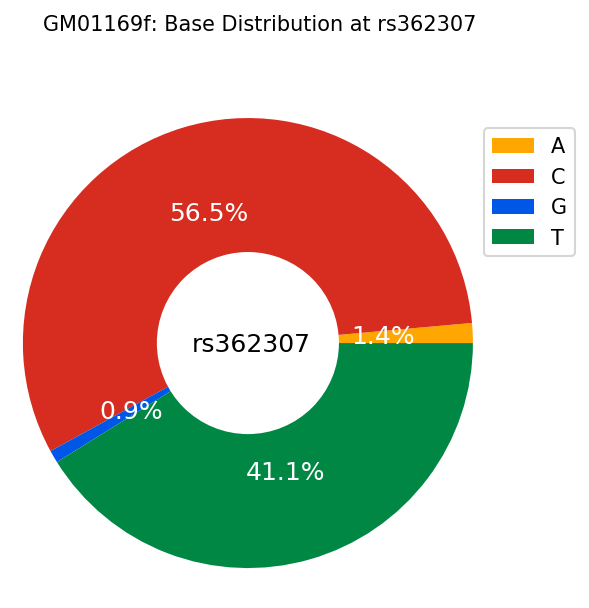

<Figure size 432x288 with 0 Axes>

In [11]:
#reusing labels and colors from 7
#circle
my_circle4=plt.Circle( (0,0), 1, color='white')

#create figure
fig = plt.figure(figsize=(4, 3), dpi=150)

#rs362331 left donut chart
ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(values_rs362307, labels = labels,colors = colors, radius = 2.5,autopct='%1.1f%%',textprops={'color':"w",'fontsize':12})
ax1.add_artist(my_circle4)
ax1.text(-0.62, -0.1, 'rs362307',fontsize=12)

#Add and position legend
ax1.legend(labels,loc = "upper right",bbox_to_anchor=(1.5, 0.5, 0.5, 1))

#Add figure title
fig.suptitle(sample_id + ": Base Distribution at rs362307", fontsize=10,x=0.27)

#Save png
plt.savefig(sample_id + "_rs362307_base_distribution.png",bbox_inches='tight')

#Show plot
plt.show()

#Clear plots
ax1.clear()
plt.clf()

### 8. Splitting df_cag into 2 dataframes by 5' or 3' alignment, merging by id, removing duplicated reads

The bowtie results for the CAG boundaries are all in one file.  In order to calculate the distance between the boundaries per read we need to first split this into 2 dataframes: 1 for 5' and one for 3'.
Once this is complete we merge these two dataframes by ID.  This will give us the coordinates of 5' and 3' boundaries in separate columns.  Finally any duplicates are removed.  This provides

* Rows with same IDs merged
* There may be duplicates at this point if query found more than once in a read / we remove duplicates
* We finally end up with a merged_cag df and we are ready to calculate CAG sizes from coordinates


In [12]:
g_cag = df_cag.groupby("query")

#Get 2 dataframes, 1 for each CAG boundary sequence 
df_cag_5 = g_cag.get_group("5_cag_border")
df_cag_3 = g_cag.get_group("3_cag_border")

#Merge dfs based on id
merged_cag = pd.merge(df_cag_5, df_cag_3, how='inner', on=("id"))

#Remove duplicates
merged_cag = merged_cag.drop_duplicates(['id'])

#Reset Index
merged_cag = merged_cag.reset_index(drop = True)

### 9. Calculate CAG repeat lengths, filter by strand, filter by CAG repeat length, assert CAG repeat

In [13]:
#Calculate CAG based on strand orientation
merged_cag.loc[((merged_cag['strand_x'] == "+") & (merged_cag['strand_y'] == "+")),'cag_repeats'] = round((merged_cag['location_y'] - merged_cag['location_x']- 14)/3)
merged_cag.loc[((merged_cag['strand_x'] == "-") & (merged_cag['strand_y'] == "-")),'cag_repeats'] = round((merged_cag['location_x'] - merged_cag['location_y'] - 14)/3)

#Filter +/- or -/+ out and leave only +/+ and -/- hits for CAG boundaries
merged_cag = merged_cag.drop(merged_cag[(merged_cag['strand_x'] == "+") & (merged_cag['strand_y'] == "-")].index)
merged_cag = merged_cag.drop(merged_cag[(merged_cag['strand_x'] == "-") & (merged_cag['strand_y'] == "+")].index)

#Filter out rows that have CAG < 0 or CAG > 150
merged_cag = merged_cag.drop(merged_cag[(merged_cag['cag_repeats'] < 0 ) | (merged_cag['cag_repeats'] > 150)].index)

#Reset Index
merged_cag = merged_cag.reset_index(drop = True)

#Drop columns not required for further analysis
merged_cag = merged_cag.loc[:,["id","cag_repeats","strand_x","location_x","location_y"]]

### 10. Merge SNP and CAG data by id and make Short/Long CAG Calls

A CAG repeat larger than 35 is characterized as expanded or long. 
A CAG repeat smaller or equal to 35 is considered short.

In [14]:
df_final = pd.merge(df_snp, merged_cag, how='inner', on=("id"))
#Drop columns not required for further analysis
df_final = df_final.loc[:,["id", "snp","base","cag_repeats","strand_x","location_x","location_y"]]

#Add column with CAG qualification (Long or Short)
df_final['cag_type'] = df_final ['cag_repeats'].apply(lambda x: 'long' if x > 35 else 'short' )

### 11. CAG Check and CAG size estimator

* We extract the actual CAG repeat sequences for the report and CAG repeat estimation.
* We measure the frequencies of C, A, G and T in every CAG repeat.
* This requires revisiting the _filtered.fasta file to extract the sequence within the CAG boundaries.
* The actual percent CAG is calculated for every extracted CAG region

In [15]:
def reverseComplement(sequence):
    translate = {"A":"T", "C":"G", "G":"C", "T":"A", "N":"N"}
    return "".join([translate[i] for i in sequence[::-1]])


def cag_correct(x):
    """
    Corrects for most frequently observed indels [not gating as CAG lengths are known]

    This correction is only used to estimate the mean, median, mode of the CAG repeat lengths from PacBio data.
    These values are previously experimentaly measured via a separate CAG repeat assay.
    Hence, this function is designed to better approximate these actual measurements and is non-gating.
    Corrections were developed based on highly prevalent observed indels in the CAG repeat regions.
    
    """
    cag_seq = x
    cag_seq = cag_seq.replace("CAG",",CAG,")
    cag_seq = cag_seq.replace("CAAG",",CAAG,")

    cag_seq_list = cag_seq.split(",")
    #Remove empty strings from list
    cag_seq_list = list(filter(lambda x: x != "", cag_seq_list))
    #CAG CORRECTION FILTERS FOR MEAN MEDIAN MODE ESTIMATION    
    #filter_remove_lone_C
    cag_seq_list = list(filter(lambda x: x != "C", cag_seq_list))
    #filter_remove_lone_G
    cag_seq_list = list(filter(lambda x: x != "G", cag_seq_list))
    #filter_remove_lone_A
    cag_seq_list = list(filter(lambda x: x != "A", cag_seq_list))
    #filter_replace_CAAG_to_CAG
    cag_seq_list[:] = [x if x != "CAAG" else 'CAG' for x in cag_seq_list]
    #filter_replace_CTAG_to_CAG
    cag_seq_list[:] = [x if x != "CTAG" else 'CAG' for x in cag_seq_list]
    #filter_replace_CA_to_CAG
    cag_seq_list[:] = [x if x != "CA" else 'CAG' for x in cag_seq_list]
    #filter_replace_AG_to_CAG
    cag_seq_list[:] = [x if x != "AG" else 'CAG' for x in cag_seq_list]
    #filter_replace_CG_to_CAG
    cag_seq_list[:] = [x if x != "CG" else 'CAG' for x in cag_seq_list]
    #merge list to string
    corrected_cag_seq = ''.join(cag_seq_list)
    return (corrected_cag_seq)

fasta = SeqIO.parse(open(fasta_file, "r"), "fasta")
#This dictionary contains ids as keys and sequences as values
fasta_d = {record.id : str(record.seq)  for record in fasta}

#GET SLICES
df_final['cag_seq'] = ""
#goal slice from sequence for each row where strand_x = "+" from location_x to location_y
df_final['cag_seq'] = df_final['id'].map(fasta_d)
df_final.loc[(df_final['strand_x'] == "+"),'cag_seq'] = df_final.apply(lambda row: row.cag_seq[row.location_x + 14:row.location_y],axis=1)
df_final.loc[(df_final['strand_x'] == "-"),'cag_seq'] = df_final.apply(lambda row: reverseComplement(row.cag_seq[row.location_y+14:row.location_x]),axis=1)
pd.set_option('display.max_colwidth', -1)

#CALCULATE FREQUENCY OF A, C, G, T
df_final['a_freq'] = round((df_final['cag_seq'].str.count("A")/(df_final['cag_seq'].str.len())*100),2)
df_final['c_freq'] = round((df_final['cag_seq'].str.count("C")/(df_final['cag_seq'].str.len())*100),2)
df_final['g_freq'] = round((df_final['cag_seq'].str.count("G")/(df_final['cag_seq'].str.len())*100),2)
df_final['t_freq'] = round((df_final['cag_seq'].str.count("T")/(df_final['cag_seq'].str.len())*100),2)

#ASSERT CAG INTEGRITY
#CALCULATE THE PERCENT CAG IN EACH EXTRACTED SEQUENCE
def calculate_cag_percent(x):
    """
    Checked for sequence length of 0 
    """
    length = len(x)
    if length == 0:
        return 0
    else:      
        cag_len =  (x.count("CAG"))* 3
        percent_cag = cag_len/length
        return round ((percent_cag*100),1)

    
df_final['percent_cag'] = df_final['cag_seq'].apply(calculate_cag_percent)

/Users/nsvrzikapa/opt/anaconda3/envs/hd/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


This is the %CAG distribution of all CAG regions that we extract via bowtie alignment.

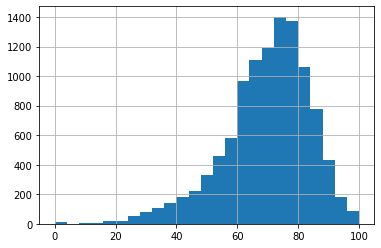

In [16]:
#This is the %CAG distribution of all CAG regions that we extract via bowtie alignment.
df_final['percent_cag'].hist(bins=25)

### 11.1 CAG percent filter and Mean, Median, Mode estimation from PacBio reads

* We assert that the extracted region is a CAG repeat region and filter any extracted region that is < 75 %CAG repeat
* We take the meean, median and mode of the short and long CAG repeats.

#### CAG filter

The CAG repeat region and the flanking regions of the CAG expansion are more prone to sequencing errors likely due to a substantially increased GC content.  We observed indels that occur in the CAG region at a higher frequencies, and to a lower degree a small percentage of reads that may be incorrectly classified as CAG due to Bowtie misalignment, or correct Bowtie alignment but high error rate (i.e. large insertion) in the CAG region.
Thus, we filter out any read where the CAG region was found to not be at least 75% CAG triplets.

In [17]:
#Filter out rows where the CAG repeat region is less than 75%CAG repeat
df_final = df_final.drop(df_final[(df_final['percent_cag'] < 75)].index)

#Reset Index
df_final = df_final.reset_index(drop = True)

#RUN CAG ERROR CORRECTION
df_final['corrected_cag'] = df_final['cag_seq'].apply(cag_correct)
df_final['percent_cag_cor'] = df_final['corrected_cag'].apply(calculate_cag_percent)
df_final['corrected_cag_repeats'] = df_final['corrected_cag'].apply(lambda x: len(x)/3)

#ESTIMATE CAG LENGTH BY TAKING MEAN, MEDIAN, MODE of short and long CAG CALLS
long_cag_mean = round(df_final.loc[df_final['cag_type'] == 'long']['corrected_cag_repeats'].mean(),1)
long_cag_median = df_final.loc[df_final['cag_type'] == 'long']['corrected_cag_repeats'].median()
long_cag_mode = df_final.loc[df_final['cag_type'] == 'long']['corrected_cag_repeats'].mode()[0]

short_cag_mean = round(df_final.loc[df_final['cag_type'] == 'short']['corrected_cag_repeats'].mean(),1)
short_cag_median = df_final.loc[df_final['cag_type'] == 'short']['corrected_cag_repeats'].median()
short_cag_mode = df_final.loc[df_final['cag_type'] == 'short']['corrected_cag_repeats'].mode()[0]

In [18]:
#must convert mode from numpy64.float to regular float for sql
short_cag_mode = short_cag_mode.item()
long_cag_mode = long_cag_mode.item()
print ("SHORT CAG READS MEAN:",short_cag_mean)
print("SHORT CAG READS MEDIAN:",short_cag_median)
print("SHORT CAG READS MODE:",short_cag_mode)
print ("LONG CAG READS MEAN:",long_cag_mean)
print("LONG CAG READS MEDIAN:",long_cag_median)
print("LONG CAG READS MODE:",long_cag_mode)

SHORT CAG READS MEAN: 16.9
SHORT CAG READS MEDIAN: 17.0
SHORT CAG READS MODE: 17.0
LONG CAG READS MEAN: 43.8
LONG CAG READS MEDIAN: 43.666666666666664
LONG CAG READS MODE: 44.0


In [19]:
#OUTPUT FINAL DF TO FILE
df_final.to_csv(sample_id + "_final_reads.csv")

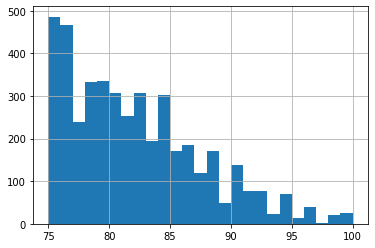

In [20]:
#This is the %CAG distribution of all CAG regions after a minimum 75%CAG filter applied
#These reads are carried forward for analysis
df_final['percent_cag'].hist(bins=25)

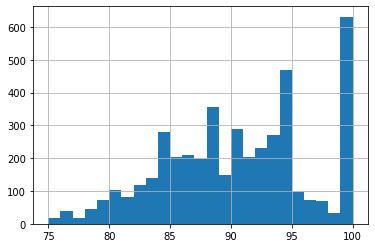

In [21]:
#This is the %CAG distribution after frequent indel correction
#Corrected prior to Mean, Median, Mode estimate from PacBio Reads
df_final['percent_cag_cor'].hist(bins=25)

#### Distribution of Short And Long CAG Repeat Regions

This plot shows the post-CAG_corrected CAG repeat distribution of reads.
The median and mean are plotted as well.
The orange and green spots represent the experimentaly measured CAG lengths of the CAGs of both alleles.

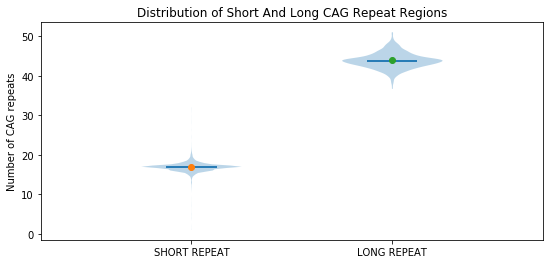

<Figure size 432x288 with 0 Axes>

In [22]:
#DATA
short = df_final.loc[df_final['cag_type'] == 'short']['corrected_cag_repeats'].to_list()
long = df_final.loc[df_final['cag_type'] == 'long']['corrected_cag_repeats'].to_list()
aggregated = [short,long]

#Create Figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), sharey=True)

#Labels
labels = ['SHORT REPEAT', 'LONG REPEAT']
#Set axi
ax1.set_title("Distribution of Short And Long CAG Repeat Regions")
ax1.set_ylabel("Number of CAG repeats")
ax1.violinplot(aggregated,showmeans=True, showmedians=True,
        showextrema=False)

ax1.set_xticklabels(labels)
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels)
ax1.set_xlim(0.25, len(labels) + 0.75)

plt.plot(1,measured_short_cag,'o')
plt.plot(2,measured_long_cag,'o')


#Save png
plt.savefig(sample_id + "_CAG_distribution.png",bbox_inches='tight')

#Show plot
plt.show()

#Clear plots
ax1.clear()
plt.clf()

### 12. Split by SNP

In [23]:
#Split final df by snp
g_final = df_final.groupby("snp")
g_final.groups.keys()
df_final_rs362331 = g_final.get_group("rs362331").reset_index(drop = True)
df_final_rs362307 = g_final.get_group("rs362307").reset_index(drop = True)

# drop the second case in a duplicate entry
# ie when the id, snp, and base are the same 
df_final_rs362307 = df_final_rs362307.drop_duplicates(["id", "snp", "base"])
df_final_rs362331 = df_final_rs362331.drop_duplicates(["id", "snp", "base"])

# drop both cases when there are two entries for the same SNP with different bases
# ie when the id and snp are the same
# this section of code MUST come after the drop case above
df_final_rs362307 = df_final_rs362307.drop_duplicates(["id", "snp"], keep=False)
df_final_rs362331 = df_final_rs362331.drop_duplicates(["id", "snp"], keep=False)

### 13. Plot histograms for each SNP

The histograms show the number of qualified reads observed on the Y axis with the CAG length on the X axis and Number.  Reads are colored based on the identity of the SNP at positions rs362331 and rs362307.

In [24]:
def plot_histogram(df,snp):
    """
    Given a dataframe and a snp returns stacked interactive histogram
    """
    a = df.loc[((df['base'] == "A")),'cag_repeats']
    c = df.loc[((df['base'] == "C")),'cag_repeats']
    g = df.loc[((df['base'] == "G")),'cag_repeats']
    t = df.loc[((df['base'] == "T")),'cag_repeats']
    
    labels = ['A', 'C', 'G', 'T']
    colors = ['#ffa700','#d62d20','#0057e7','#008744']
    df_data = [a,c,g,t]
    
    
    plt.figure(figsize=(5, 3), dpi=150)

    plt.hist(df_data, 150, histtype='bar', stacked=True, label = labels,color=colors, range = (0,150))
    plt.legend(labels,loc = "upper right",bbox_to_anchor=(0, 1, 1, 0))
    
    plt.title(sample_id + "_" + snp)
    plt.ylabel("Number of Reads")
    plt.xlabel("CAG Repeats")

    plt.savefig(sample_id + "_" + snp + "_" + "histogram.png",bbox_inches='tight')
    plt.show()

    #Clear plots
    plt.clf()

### 13.1 Plot Histogram for rs362331

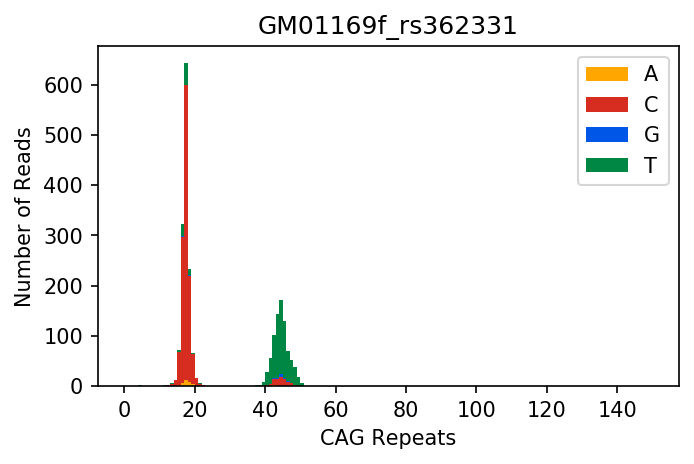

<Figure size 432x288 with 0 Axes>

In [25]:
plot_histogram(df_final_rs362331,"rs362331")

### 13.2 Plot Histogram for rs362307

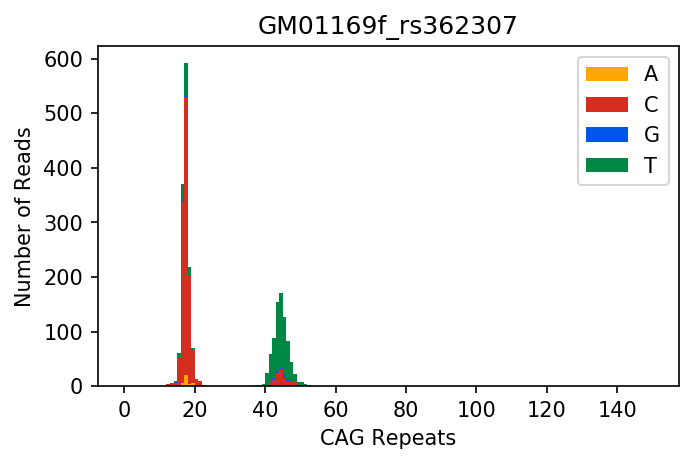

<Figure size 432x288 with 0 Axes>

In [26]:
plot_histogram(df_final_rs362307,"rs362307")

### We are starting with the two final dfs that have been filtered and duplicates have been removed for each snp.

* Add another column base_cag merging the base with its corresponding cag_type (_short or _long)
* Create a groupby object grouping on snp, base and base_cag (g_rs362307, g_rs362331)
* Create a dictionary for quick retrieval of the groupby objects d
* Create a list of lists with counts values for each base
* Create the final df from the list of lists: df_counts


In [27]:

df_final_rs362307['base_cag'] = df_final_rs362307['base'] + "_" + df_final_rs362307['cag_type']
df_final_rs362331['base_cag'] = df_final_rs362331['base'] + "_" + df_final_rs362331['cag_type']


#make a count df at position 3 for all base long shorts
bases = list('ACGT')
base_types = ['_short','_long']
g_rs362307 = df_final_rs362307.groupby(['snp', 'base','base_cag'])
g_rs362331 = df_final_rs362331.groupby(['snp', 'base','base_cag'])

#dictionary of groupby objects
d = {'rs362307':g_rs362307,
     'rs362331':g_rs362331}

count_list = []
snps = ["rs362307","rs362331"]

#populate a list of lists to create the final df
for snp in snps:
    temp_list = []
    temp_list.append(snp)
    for base in bases:
        for base_type in base_types:
            try:
                temp_list.append(d[snp].get_group((snp,base,(base + base_type)))['base_cag'].count())
            except:
                temp_list.append(0)
    count_list.append(temp_list)
    
df_counts = pd.DataFrame(count_list, columns=['snp', 'A_short', 'A_long', 'C_short', 'C_long','G_short', 'G_long', 'T_short', 'T_long'])


### Processing of df_counts
* Aggregate the percentages for each base sum of (base_long + base_short) / all bases 

In [28]:
df_counts

,snp,A_short,A_long,C_short,C_long,G_short,G_long,T_short,T_long
0,rs362307,36,3,1202,118,3,17,126,667
1,rs362331,34,4,1261,84,4,14,98,725


In [29]:
#Base counts sums
for base in bases:
    df_counts[base] = round(((df_counts[base + base_types[0]] + df_counts[base + base_types[1]])/(df_counts['A_short'] + df_counts['A_long'] + 
       df_counts['C_short']+df_counts['C_long']+
       df_counts['G_short']+df_counts['G_long']+
       df_counts['T_short']+df_counts['T_long'])*100),2)

#A function to estimate the zygosity given percentages of A C G T with 10% threshold
def estimate_zygocity(row):
    count = 0
    bases = list('CT')
    for base in bases:
        if row[base] > 10:
            count +=1
    if count == 2:
        return 1
    else:
        return 0
#A function to estimate the top 2 bases
def estimate_top_two(row):
    top = []
    bases = list('CT')
    for base in bases:
        if row[base] > 10:
            top.append(base)
    if len(top) == 2:
        return(top)
    else:
        return np.nan
def base_on_long(row):
    if isinstance(row['top'], float):
        return np.nan
    else:
        first_long = row[row['top'][0] + "_long"]
        first_short = row[row['top'][0] + "_short"]
        second_long = row[row['top'][1] + "_long"]
        second_short = row[row['top'][1] + "_short"]
        #Add one in case 0
        first_long += 1
        first_short +=1
        second_long +=1
        second_short +=1
        total = first_long + first_short + second_long + second_short
        #print ("total",total)
        x = np.arange(0.0, 1.001, 0.001)

        #Prior
        def func_prior(x):
            return beta.pdf(x,total/4,total/4)**2

        q_prior,q_prior_error = integrate.quad(func_prior,0,1)
        PRIOR = array([val / q_prior for val in func_prior(x)])
        PRIOR[PRIOR == 0] = np.min(PRIOR[np.nonzero(PRIOR)])
        #print (PRIOR[0])
        def func_lik(x):
            return beta.pdf(x,first_long,first_short) * beta.pdf(x,second_short,second_long)

        q_lik,q_lik_error = integrate.quad(func_lik,0,1)
        LIK = array([val / q_lik for val in func_lik(x)])
        LIK[LIK == 0] = np.min(LIK[np.nonzero(LIK)])
        #print (LIK[0])

        #Posterior
        def func_posterior(x):
            return beta.pdf(x,total/4 + first_long, total/4 + first_short) * beta.pdf(x,total/4 + second_short, total/4 + second_long)

        q_posterior,q_error = integrate.quad(func_posterior,0,1)
        POSTERIOR = array([val / q_posterior for val in func_posterior(x)])
        POSTERIOR[POSTERIOR == 0] = np.min(POSTERIOR[np.nonzero(POSTERIOR)])
        #print (POSTERIOR[0])
        getMax = int(max(max(POSTERIOR), max(LIK),max(PRIOR)))

        #Bayes Factor
        BF = PRIOR[x == .5] / POSTERIOR[x == .5]
        BF = BF[0]
        #Lower and upper highest posterior density (HPD)
        alpha = 0.05
        X = np.arange(0.0, 1.0001, 0.0001)
        betacdf = np.cumsum(func_posterior(X))
        betacdf = betacdf / np.max(betacdf)

        hpd_lower = X[(abs(betacdf - alpha/2) == np.min(abs(betacdf - alpha/2)))][0]
        hpd_upper = X[(abs(betacdf -(1- alpha/2)) == np.min(abs(betacdf - (1-alpha/2))))][0]


        #Phasing is switched with confidence
        #Given that we always pass first C then T in order
        # hpd <0.5 means T is on LONG and C is on short
        if hpd_lower < 0.5 and hpd_upper < 0.5 and BF > 1000000:
            return row['top'][1]
        #Phasing is switched with confidence
        elif hpd_lower > 0.5 and hpd_upper > 0.5 and BF > 1000000:
            return row['top'][0]
        else:
            return np.nan
df_counts['sample'] = sample_id   
df_counts['zygosity'] = df_counts.apply(estimate_zygocity, axis = 1)
df_counts['top'] = df_counts.apply(estimate_top_two, axis = 1)
df_counts['on_long'] = df_counts.apply(base_on_long, axis = 1)
df_counts['phased'] = df_counts['on_long'].apply(lambda x: 1 if x in bases else 0)

In [30]:
df_counts

,snp,A_short,A_long,C_short,C_long,G_short,G_long,T_short,T_long,A,C,G,T,sample,zygosity,top,on_long,phased
0,rs362307,36,3,1202,118,3,17,126,667,1.80,60.77,0.92,36.51,GM01169f,1,"[C, T]",T,1
1,rs362331,34,4,1261,84,4,14,98,725,1.71,60.48,0.81,37.01,GM01169f,1,"[C, T]",T,1


### 14. Getting final counts of sequences with T (long/short) and C (long/short) for both SNPs


In [31]:
try:
    rs362331_T_long = df_final_rs362331.groupby(["base", "cag_type"]).size()["T"]["long"]
except:
    rs362331_T_long = 0
try:
    rs362331_T_short = df_final_rs362331.groupby(["base", "cag_type"]).size()["T"]["short"]
except:
    rs362331_T_short = 0
try:
    rs362331_C_long = df_final_rs362331.groupby(["base", "cag_type"]).size()["C"]["long"]
except:
    rs362331_C_long = 0
try:
    rs362331_C_short = df_final_rs362331.groupby(["base", "cag_type"]).size()["C"]["short"]
except:
    rs362331_C_short = 0
try:
    rs362307_T_long = df_final_rs362307.groupby(["base", "cag_type"]).size()["T"]["long"]
except:
    rs362307_T_long = 0
try:
    rs362307_T_short = df_final_rs362307.groupby(["base", "cag_type"]).size()["T"]["short"]
except:
    rs362307_T_short = 0
try:
    rs362307_C_long = df_final_rs362307.groupby(["base", "cag_type"]).size()["C"]["long"]
except:
    rs362307_C_long = 0
try:    
    rs362307_C_short = df_final_rs362307.groupby(["base", "cag_type"]).size()["C"]["short"]
except:
    rs362307_C_short = 0
    
#These counts are saved in the output csv and db table as json    
counts = [['rs362331_T_long','rs362331_T_short','rs362331_C_long','rs362331_C_short'],
          [int(rs362331_T_long),int(rs362331_T_short),int(rs362331_C_long),int(rs362331_C_short)],
          ['rs362307_T_long','rs362307_T_short','rs362307_C_long','rs362307_C_short'],
          [int(rs362307_T_long),int(rs362307_T_short),int(rs362307_C_long),int(rs362307_C_short)]]


### 15. Statistics

Bayesian statistics for calculating confidence on making the Eligibility call for each SNP.
The BF treshold is set to 1:1000000 for making a call for T associated with the LONG CAG REPEAT.

In [32]:
def statistics(T_long,T_short, C_long, C_short, snp):
     
    global bf_rs362331
    global hpd_lower_rs362331
    global hpd_upper_rs362331
    global bf_rs362307
    global hpd_lower_rs362307
    global hpd_upper_rs362307
    global rs_362331_eligibility
    global rs_362307_eligibility
    global comments

     
    T_long += 1
    T_short +=1
    C_long +=1
    C_short +=1
    total = T_long + T_short + C_long + C_short
    #print ("total",total)
    x = np.arange(0.0, 1.001, 0.001)

    #Prior
    def func_prior(x):
        return beta.pdf(x,total/4,total/4)**2

    q_prior,q_prior_error = integrate.quad(func_prior,0,1)
    PRIOR = array([val / q_prior for val in func_prior(x)])
    PRIOR[PRIOR == 0] = np.min(PRIOR[np.nonzero(PRIOR)])
    #print (PRIOR[0])
    def func_lik(x):
        return beta.pdf(x,T_long,T_short) * beta.pdf(x,C_short,C_long)

    q_lik,q_lik_error = integrate.quad(func_lik,0,1)
    LIK = array([val / q_lik for val in func_lik(x)])
    LIK[LIK == 0] = np.min(LIK[np.nonzero(LIK)])
    #print (LIK[0])

    #Posterior
    def func_posterior(x):
        return beta.pdf(x,total/4 + T_long, total/4 + T_short) * beta.pdf(x,total/4 + C_short, total/4 + C_long)

    q_posterior,q_error = integrate.quad(func_posterior,0,1)
    POSTERIOR = array([val / q_posterior for val in func_posterior(x)])
    POSTERIOR[POSTERIOR == 0] = np.min(POSTERIOR[np.nonzero(POSTERIOR)])
    #print (POSTERIOR[0])
    getMax = int(max(max(POSTERIOR), max(LIK),max(PRIOR)))

    #Bayes Factor
    BF = PRIOR[x == .5] / POSTERIOR[x == .5]
    BF = BF[0]
    #Lower and upper highest posterior density (HPD)
    alpha = 0.05
    X = np.arange(0.0, 1.0001, 0.0001)
    betacdf = np.cumsum(func_posterior(X))
    betacdf = betacdf / np.max(betacdf)

    hpd_lower = round(X[(abs(betacdf - alpha/2) == np.min(abs(betacdf - alpha/2)))][0],2)
    hpd_upper = round(X[(abs(betacdf -(1- alpha/2)) == np.min(abs(betacdf - (1-alpha/2))))][0],2)
    
    #OFFLINE PLOTS
    # Create and style traces
    labels = ["Prior","Likelihood","Posterior"]
    plt.figure(figsize=(5, 3), dpi=150)
    plt.plot(x, PRIOR, color='red')
    plt.plot(x, LIK, color='green')
    plt.plot(x, POSTERIOR, color='blue')
    plt.ylim(top=getMax + 16)
    plt.legend(labels,loc = "upper right",bbox_to_anchor=(0, 1, 1, 0),prop={'size': 6})
    plt.title(sample_id + "_" + snp)
    plt.xlabel('P(T on long CAG, C on short CAG)')
    plt.ylabel('Probability Density')
    plt.text(0, plt.gca().get_ylim()[1] -3, "BF ="+str(BF), fontsize=8)
    plt.text(0,plt.gca().get_ylim()[1] -7,'95% HPD = [' + str(hpd_lower) + "," + str(hpd_upper) + "]", fontsize=8)


    
    #Assign Values to bf, hpd_lower and upper per SNP
    if snp == "rs362331":
        bf_rs362331 = BF
        hpd_lower_rs362331 = hpd_lower
        hpd_upper_rs362331 = hpd_upper
    if snp == "rs362307":
        bf_rs362307 = BF
        hpd_lower_rs362307 = hpd_lower
        hpd_upper_rs362307 = hpd_upper
 
    #Phasing is switched with confidence
    if hpd_lower < 0.5 and hpd_upper < 0.5 and BF > 1000000 and T_short >= 30:
        print (snp, "BF:",BF, "HPD_Lower:",hpd_lower,"HPD_Upper:",hpd_upper)
        result = "NOT ELIGIBLE FOR " + snp + ": T ON SHORT CAG / C ON LONG CAG "
        print (result)
        comments.append(result)
        plt.savefig(sample_id + "_" + snp + "_" + "statistics.png",bbox_inches='tight')
        plt.show()
        plt.clf()

    
    #Phasing is switched with confidence but T on short cag is not observed
    if hpd_lower < 0.5 and hpd_upper < 0.5 and BF > 1000000 and T_short < 30:
        result = "NOT ELIGIBLE FOR " + snp + " : LOW T COUNTS ON SHORT CAG"
        comments.append(result)
        print (result)
        
    #Phasing is optimal
    if hpd_lower > 0.5 and hpd_upper > 0.5 and BF > 1000000 and T_long >= 30:
        result = "ELIGIBLE FOR " + snp + " : T ON LONG CAG / C ON SHORT CAG"
        print (result)
        comments.append(result)
        
        if snp == "rs362331":
            rs_362331_eligibility = "ELIGIBLE"
        elif snp == "rs362307":
            rs_362307_eligibility = "ELIGIBLE"
        #save plot file
        plt.savefig(sample_id + "_" + snp + "_" + "statistics.png",bbox_inches='tight')
        plt.show()
        plt.clf()

    
    #Phasing is optimal, there is confidence,  but T is not observed on Long CAG
    if hpd_lower > 0.5 and hpd_upper > 0.5 and BF > 1000000 and T_long < 30:
        result = "NOT ELIGIBLE FOR " + snp + " : LOW T COUNTS ON LONG CAG"
        print (result)
        comments.append(result)
        print (snp, "BF:",BF, "HPD_Lower:",hpd_lower,"HPD_Upper:",hpd_upper)

    #Phasing is switch but there is not enough confidence
    if hpd_lower < 0.5 and hpd_upper < 0.5 and BF < 1000000 and T_short >= 30:
        result = "NOT ELIGIBLE FOR" + snp + ": T ON SHORT CAG / C ON LONG CAG, NOT ENOUGH EVIDENCE, BF < 1000000 "
        print (result)
        comments.append(result)
        print (snp, "BF:",BF, "HPD_Lower:",hpd_lower,"HPD_Upper:",hpd_upper)
        plt.savefig(sample_id + "_" + snp + "_" + "statistics.png",bbox_inches='tight')
        plt.show()
        plt.clf()
    
    #Not enough evidence for T on long and C on short CAG
    if hpd_lower > 0.5 and hpd_upper > 0.5 and BF < 1000000 and T_long >= 30:
        result = ("NOT ELIGIBLE FOR" + snp + ": T ON LONG CAG / C ON SHORT CAG, NOT ENOUGH EVIDENCE, BF < 1000000")
        print (result)
        print (snp, "BF:",BF, "HPD_Lower:",hpd_lower,"HPD_Upper:",hpd_upper)
        plt.savefig(sample_id + "_" + snp + "_" + "statistics.png",bbox_inches='tight')
        plt.show()
        plt.clf()

### 15.1 Statistics Calculation and plot for rs362331

ELIGIBLE FOR rs362331 : T ON LONG CAG / C ON SHORT CAG


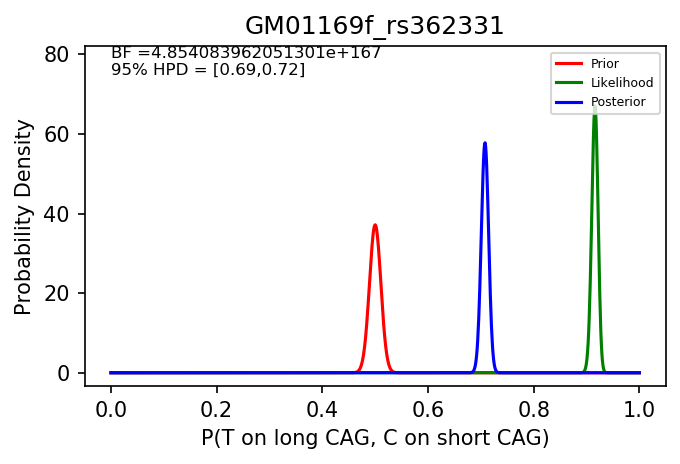

<Figure size 432x288 with 0 Axes>

In [33]:
bf_rs362331 = None
hpd_lower_rs362331 = None
hpd_upper_rs362331 = None
bf_rs362307 = None
hpd_lower_rs362307 = None
hpd_upper_rs362307 = None

if sanger_rs362331_het == True:
    statistics(rs362331_T_long,rs362331_T_short,rs362331_C_long,rs362331_C_short,"rs362331")
else:
    print ("SAMPLE NOT ELIGIBLE FOR ANALYSIS of rs362331: NOT HETEROZYGOUS AT rs362331 SNP")

### 15.2 Statistics Calculation and plot for rs362307

ELIGIBLE FOR rs362307 : T ON LONG CAG / C ON SHORT CAG


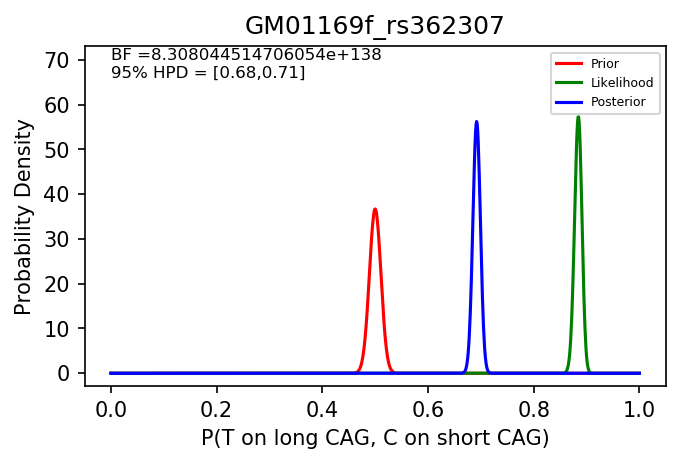

<Figure size 432x288 with 0 Axes>

In [34]:
if sanger_rs362307_het == True:
    statistics(rs362307_T_long,rs362307_T_short,rs362307_C_long,rs362307_C_short,"rs362307")
else:
    print ("SAMPLE NOT ELIGIBLE FOR ANALYSIS of rs362307: NOT HETEROZYGOUS AT rs362307 SNP")

### 16. Final Data Output

In [35]:
#BF per SNP
try:
    bf_rs362331 = float(bf_rs362331)
except:
    bf_rs362331 = None
try:
    bf_rs362307 = float(bf_rs362307)
except:
    bf_rs362307 = None
try:
    hpd_lower_rs362331 = round(float(hpd_lower_rs362331),2)
except:
    hpd_lower_rs362331 = None
try:
    hpd_upper_rs362331 = round(float(hpd_upper_rs362331),2)
except:
    hpd_upper_rs362331 = None
try:
    hpd_lower_rs362307 = round(float(hpd_lower_rs362307),2)
except:
    hpd_lower_rs362307 = None
try:
    hpd_upper_rs362307 = round(float(hpd_upper_rs362307),2)
except:
    hpd_upper_rs362307 = None
    
short_cag_mean = float(short_cag_mean)
short_cag_median = float(short_cag_median)
try:
    short_cag_mode = round (float(short_cag_mode),2)
except:
    short_cag_mode = round(float(short_cag_mode[0]),2)
long_cag_mean = float(long_cag_mean)
long_cag_median = float(long_cag_median)

try:
    long_cag_mode = round(float(long_cag_mode),2)
except:
    long_cag_mode = round(float(long_cag_mode[0]),2)

print ("Sample ID: ",sample_id)
print ("bf_rs362331: ",bf_rs362331)
print ("hpd_lower_rs362331: ",hpd_lower_rs362331)
print ("hpd_upper_rs362331: ",hpd_upper_rs362331)

print ("bf_rs362307: ",bf_rs362307)
print ("hpd_lower_rs362307: ",hpd_lower_rs362307)
print ("hpd_upper_rs362307: ",hpd_upper_rs362307)

print ("Analyst",analyst_information)
print ("rs_362331_het ?",sanger_rs362331_het)
print ("rs_362307_het ?",sanger_rs362307_het)

print ("Facility", facility)

#Entered CAG Size
print ("Entered Value for short CAG: ", measured_short_cag)
print ("Entered Value for long CAG: ", measured_long_cag)


#Estimated CAG Size
print ("SHORT CAG MEAN:", short_cag_mean)
print ("SHORT CAG MEDIAN:", short_cag_median)
print ("SHORT CAG MODE:", short_cag_mode)

print ("LONG CAG MEAN:", long_cag_mean)
print ("LONG CAG MEDIAN:", long_cag_median)
print ("LONG CAG MODE:", long_cag_mode)

#Comments

print ("Comments:")
for comment in comments:
    print (comment)
comments = json.dumps(comments)    
#Eligibility
print ("Eligible for rs362331: ", rs_362331_eligibility)
print ("Eligible for rs362307: ", rs_362307_eligibility)
print ("Script Version: ", script_version)

#Counts
counts = json.dumps(counts)
print (counts)

Sample ID:  GM01169f
bf_rs362331:  4.854083962051301e+167
hpd_lower_rs362331:  0.69
hpd_upper_rs362331:  0.72
bf_rs362307:  8.308044514706054e+138
hpd_lower_rs362307:  0.68
hpd_upper_rs362307:  0.71
Analyst Test User
rs_362331_het ? True
rs_362307_het ? True
Facility External_User
Entered Value for short CAG:  17
Entered Value for long CAG:  44
SHORT CAG MEAN: 16.9
SHORT CAG MEDIAN: 17.0
SHORT CAG MODE: 17.0
LONG CAG MEAN: 43.8
LONG CAG MEDIAN: 43.666666666666664
LONG CAG MODE: 44.0
Comments:
ELIGIBLE FOR rs362331 : T ON LONG CAG / C ON SHORT CAG
ELIGIBLE FOR rs362307 : T ON LONG CAG / C ON SHORT CAG
Eligible for rs362331:  ELIGIBLE
Eligible for rs362307:  ELIGIBLE
Script Version:  3.3
[["rs362331_T_long", "rs362331_T_short", "rs362331_C_long", "rs362331_C_short"], [725, 98, 84, 1261], ["rs362307_T_long", "rs362307_T_short", "rs362307_C_long", "rs362307_C_short"], [667, 126, 118, 1202]]


### 17. Export final data to csv

sample_id + _output.csv is generated with critical analytical information.

In [36]:
time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
mydata = [[time,facility,analyst_information, sample_id,script_version,
         measured_short_cag,short_cag_mode, measured_long_cag,long_cag_mode,
         sanger_rs362331_het, sanger_rs362307_het,
         bf_rs362331,hpd_lower_rs362331,hpd_upper_rs362331,rs_362331_eligibility,
         bf_rs362307,hpd_lower_rs362307,hpd_upper_rs362307,rs_362307_eligibility,counts]]

df_csv = pd.DataFrame(mydata, columns=['Date','Facility','Analyst','Sample ID','Script Version',
                              'Entered Short CAG','Mode Short CAG','Entered Long CAG','Mode Long CAG',
                              'Entered Het for rs362331','Entered Het for rs362307',
                              'bf_rs362331','hpd_lower_rs362331','hpd_upper_rs362331','Eligibility rs362331 [SNP2]',
                              'bf_rs362307','hpd_lower_rs362307','hpd_upper_rs362307','Eligibility rs362307 [SNP1]','Counts'])
df_csv.to_csv(sample_id + "_output.csv", sep=',')